# Gaussian Process on the toy data set from ../datasets/toy.ipynb

# Github

In [1]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Project18/GPs


# Imports

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/datasets


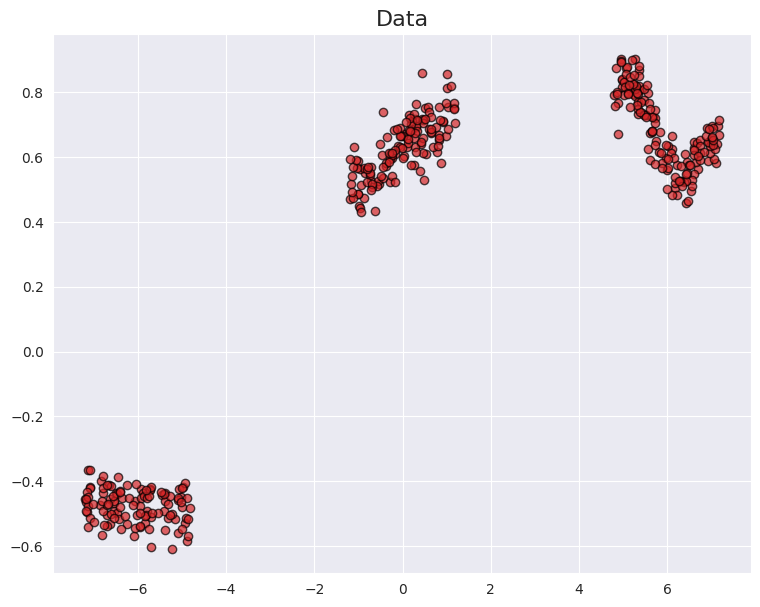

To https://github.com/Sabelz/Project18.git
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'https://github.com/Sabelz/Project18.git'
hint: Updates were rejected because the remote contains work that you do
hint: not have locally. This is usually caused by another repository pushing
hint: to the same ref. You may want to first integrate the remote changes
hint: (e.g., 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
#!pip install gpytorch
import gpytorch
%run ../datasets/toy.ipynb # Run the toy notebook which is in the datasets folder(toy dataset)

# Training data from toy.ipynb

In [9]:
xTrain, yTrain = x, y # x, y are defined in ../datasets/toy.ipynb
xTrain, yTrain = torch.from_numpy(xTrain), torch.from_numpy(yTrain) # Convert them to tensors

# The GP model

In [11]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [12]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(xTrain, yTrain, likelihood) # For the first example, RBF kernel is used

# Train the model

In [13]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(xTrain)
    # Calc loss and backprop gradients
    loss = -mll(output, yTrain)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.790   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.751   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.713   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.673   lengthscale: 0.854   noise: 0.554
Iter 5/50 - Loss: 0.634   lengthscale: 0.911   noise: 0.513
Iter 6/50 - Loss: 0.593   lengthscale: 0.971   noise: 0.474
Iter 7/50 - Loss: 0.553   lengthscale: 1.032   noise: 0.437
Iter 8/50 - Loss: 0.511   lengthscale: 1.094   noise: 0.403
Iter 9/50 - Loss: 0.469   lengthscale: 1.158   noise: 0.370
Iter 10/50 - Loss: 0.426   lengthscale: 1.222   noise: 0.340
Iter 11/50 - Loss: 0.383   lengthscale: 1.287   noise: 0.312
Iter 12/50 - Loss: 0.340   lengthscale: 1.353   noise: 0.286
Iter 13/50 - Loss: 0.295   lengthscale: 1.418   noise: 0.261
Iter 14/50 - Loss: 0.251   lengthscale: 1.483   noise: 0.239
Iter 15/50 - Loss: 0.206   lengthscale: 1.548   noise: 0.218
Iter 16/50 - Loss: 0.161   lengthscale: 1.613   noise: 0.199
Iter 17/50 - Loss: 0.115   length

# Test data

In [24]:
# Observing the plot of the toy dataset, x varies between -7-7
xTest = torch.linspace(-9, 9, 50)

# The posterior mean, variance and Covariance Matrix

In [25]:
model.eval() # eval mode is for computing predictions through the model posterior
f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
f_mean = f_preds.mean # Predictive mean
f_var = f_preds.variance # Predictive variance
f_covar = f_preds.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean.size())
print()
print("Variance Dimension: ", f_var.size())
print()
print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([50])

Variance Dimension:  torch.Size([50])

CovMatrix Dimension  torch.Size([50, 50])


# Plots of samples from the GP

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


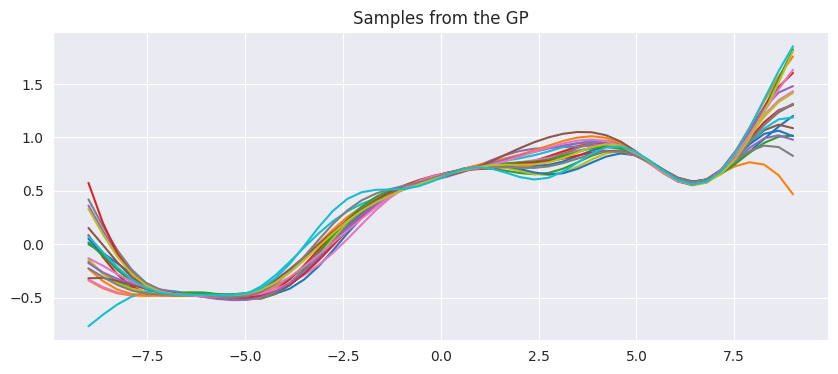

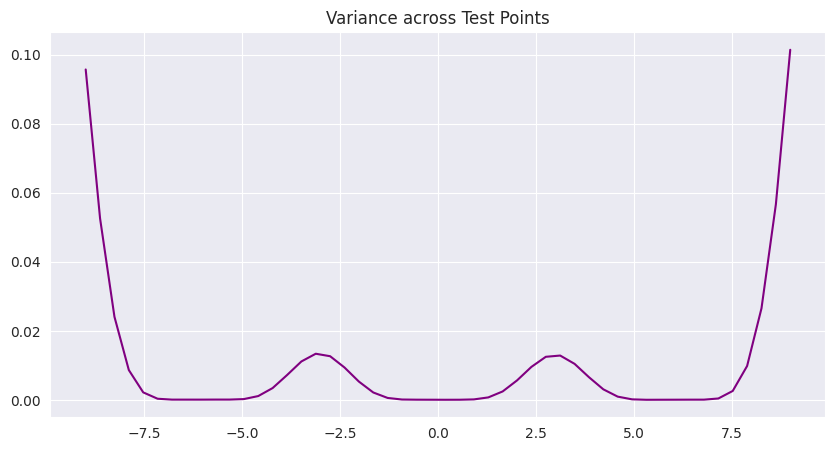

In [26]:
# Convert to numpy
xTestPlot = xTest.detach().numpy()
f_meanPlot = f_mean.detach().numpy()
f_varPlot = f_var.detach().numpy()
# Plot samples from the GP
plt.figure(figsize=(10, 4))
for i in range(20):  # Generate 20 samples
    f_sample = f_preds.sample().detach().numpy()
    plt.plot(xTestPlot, f_sample)
plt.title('Samples from the GP')
plt.show()
# Plot variance
plt.figure(figsize=(10, 5))
plt.plot(xTestPlot, f_varPlot, 'purple')
plt.title('Variance across Test Points')
plt.show()

# Predictive Distribution

In [27]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()



# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

# Plot with RBF kernel

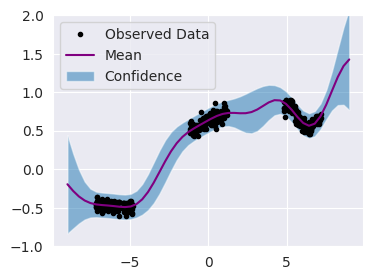

In [28]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(xTrain.numpy(), yTrain.numpy(), 'k.')
    # Plot predictive means as purple line
    ax.plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

GPToy  GPWiggle.ipynb
